**Content**



*   Problem Statemt
*   Importing Necessary Packages
*   About the Data
      * Decoding the File Names
      * Terms Explanation
*   Data Exploration
      * Data Preparation
*   VGG 16
      * Plain Vanilla Form
      * VGG16 with Data Augumentation
*   Transfer Learning
      * VGG16
      * Resnet
      *Inception V3
*  Introducting Real world picture
      * VGG16
      * Resnet
      * Inception V3
*  Stacking
*  Visualizing the results




## **Problem Statement:**

The problem would be on object detection, where training images are just instances of the object. 

This is unlike normal object detection where train and test images are scenes with objects inside them are tagged with a bounding box.
You can download the dataset from here -> https://github.com/gulvarol/grocerydataset.

Dataset description is given in detail there, I'm describing below your task requirements.

There are 10 classes (cigarette brand) and we want you to detect the brands in the shop images (ie localize the boxes and classify the brand)

Trainset -> './BrandImages'

Testset   -> './ShelfImages'

Testset Annotations -> './BrandImagesFromShelves'

Accuracy Metric -> Standard object detection metric, mAP. (Please include visualizations of predictions)



## Importing Necessary Packages

In [3]:
import os                            ## To access local drive
import cv2                           ## Image handling
import pandas as pd                  ## Read Csv Files                                                 
import numpy as np                   ## Mathematical Operations



## Packages necessary for Plotting the images
import matplotlib.pyplot as plt
import seaborn as sns

### Packages Necessary for building the Models
from keras.layers import Dense,Flatten,MaxPooling2D,Convolution2D,Dropout,GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import applications
from keras.applications.vgg16  import VGG16
from keras.models import Sequential, load_model, Model
from keras.utils import np_utils

## Packages necessary for Image Augumentation
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator


## Packages necessary for basic model Inference
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score, precision_score

## **About the Data**

The Grocery Dataset is an image dataset:

* Collected from ~40 groceries, with 4 cameras,

* With 10 product categories,

### **Decoding the File Names**

#### BrandImages

This folder contains the cropped versions of the ProductImages directory. The images are cropped so that only the brand logo remains. This is our Train Data

  The naming is as follows:

		"B<b>_N<N>.JPG"
			where
				<b> := brand id
				<n> := copy number

#### Shelve Images

There are total of 354 images in the shelf folder which is our test data,

Naming convention of the Test Data File,



      C<c>_P<p>_N<n>_S<s>_<i>.JPG
		
      where,
				
          <c> := camera id (1: iPhone5S, 2: iPhone4, 3: Sony Cybershot, 4: Nikon Coolpix)
				<p> := planogram id
				<n> := the rank of the top shelf on the image according to the planogram
				<s> := number of shelves on the image
				<i> := copy number


#### BrandImagesFromShelves
This folder contains the cropped versions of the ProductImagesFromShelves directory. The images are cropped so that only the brand logo remains.

The naming is as follows:

			<shelf image name>_<x>_<y>_<w>_<h>.png
			where
			<shelf image name>   := the source image where the image is cropped from
			<x>                  := x-coordinate of the image's top-left corner on the source image
			<y>                  := y-coordinate of the image's top-left corner on the source image
			<w>                  := width of the image on the source image
			<h>                  := height of the image on the source image

### **Terms Expalantaion**


**Palanogram:**

A planogram is a diagram that shows how and where specific retail products should be placed on retail shelves or displays in order to increase customer purchases.


**Camera** 

There are four different types cameras which are used to take images of the shelves. As mentioned above. 


As  I have mentioned things clearly, let's start exploring the dataset before diving into the object detection part.

## **Data Exploration**

While exploring the data set manually for a better understanding it is found that, there are few data points that are skewed(rotated), which made to correct position manually. 

In [4]:
from os import walk

## Directory of the image Files
train_data = "/content/drive/MyDrive/Grocery Data/BrandImages/"
test_data = "/content/drive/MyDrive/Grocery Data/ShelfImages/"
annotation_data = "/content/drive/MyDrive/Grocery Data/BrandImagesFromShelves/"

classes = [str(i) for i in range(1,11)]

In [5]:
### Function to form a dataframe that contains annotation information of the test data.
### The test data annotation information get through the file names of the folder BrandImagesFromShelves
def get_annotation():
  filename = []
  shelf = []
  planogram = []
  xmin = []
  ymin = []
  width = []
  height = []
  class_ = []

  ## Reading the file name Class-wise and get output a dataframe as containing annotation details
  for i in range(1,11):
    for file_ in os.listdir(annotation_data+str(i)+'/'):
      filename.append(file_.split('.JPG')[0]+'.JPG')
      shelf.append(file_.split('.JPG')[0][:6])
      planogram.append(file_.split('.JPG')[0][7:14])
      file_ = file_.split('.JPG')[-1].replace('.png','').split('_')
      xmin.append(int(file_[len(file_)-4]))
      ymin.append(int(file_[len(file_)-3]))
      width.append(int(file_[len(file_)-2]))
      height.append(int(file_[len(file_)-1]))
      class_.append(i)

  xmax = [int(xmin[i]) + int(width[i]) for i in range(0,len(xmin))]
  ymax = [int(ymin[i]) + int(height[i]) for i in range(0,len(ymin))]

  annotation_df = pd.DataFrame()
  annotation_df['filename'] = filename
  annotation_df['Shelf_id'] = shelf
  annotation_df['Planogram_id'] = planogram
  annotation_df['xmin'] = xmin
  annotation_df['ymin'] = ymin
  annotation_df['width'] = width
  annotation_df['height'] = height
  annotation_df['xmax'] = xmax
  annotation_df['ymax'] = ymax
  annotation_df['Class'] = class_

  return annotation_df


annotation_df = get_annotation()

In [6]:
annotation_df.head()

,filename,Shelf_id,Planogram_id,xmin,ymin,width,height,xmax,ymax,Class
0,C1_P01_N2_S4_1.JPG,C1_P01,N2_S4_1,912,752,260,440,1172,1192,1
1,C1_P01_N1_S3_1.JPG,C1_P01,N1_S3_1,1276,1828,276,448,1552,2276,1
2,C1_P01_N2_S4_1.JPG,C1_P01,N2_S4_1,1140,820,260,404,1400,1224,1
3,C1_P01_N1_S3_1.JPG,C1_P01,N1_S3_1,1548,1836,276,448,1824,2284,1
4,C1_P01_N1_S5_1.JPG,C1_P01,N1_S5_1,1068,1108,208,308,1276,1416,1


Now that we have created a annotation dataframe, let's try to see how the annotation looks like on a test data.

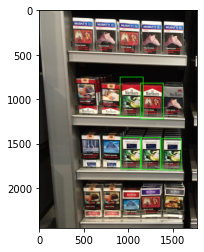

In [11]:
## Function to Understand, how image annotation works
def draw_annotated_image(filename):
    coordinates = annotation_df[annotation_df.filename == filename][['xmin', 'ymin', 'xmax', 'ymax']].values

    ## Reading the image files
    im = cv2.imread(test_data+filename)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 
    
    ## Draw coordinates
    for xmin, ymin, xmax, ymax in coordinates:
        cv2.rectangle(im, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 5)
    
    plt.imshow(im)

draw_annotated_image(annotation_df['filename'][0])

### Data Preparation

In [7]:
## Function to read Train data
def get_train_data():
  X = []
  Y =  []

  for i in range(1,11):
    for file_ in os.listdir(train_data+str(i)+'/'):
      try:
        image = cv2.imread(train_data+str(i)+'/'+file_, cv2.IMREAD_GRAYSCALE) ## Reading the images as grayscale
        image = cv2.resize(image,(224,224))                                  ## Resizing the images to 224x224 as vgg-16 formal size
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                       ## Converting back to RGB 
        X.append(image)                                                      ## Adding image to Train X 
        Y.append(i)                                                           ## Adding class Y
      except:
        continue 
  return X,Y                                                          

In [8]:
## Function to get Test Data
def get_test_data():
  test_x = []
  test_y = []

  for i in range(0,len(annotation_df)):
    Class,xmin,ymin,xmax,ymax = annotation_df.iloc[i][['Class', 'xmin', 'ymin', 'xmax', 'ymax']]
    image = cv2.imread(test_data+annotation_df.iloc[i]['filename'], cv2.IMREAD_GRAYSCALE) ## Reading the images as grayscale
    try:
      image = (np.array(image[ymin:ymax, xmin:xmax]))
      image = cv2.resize(image,(224,224))                                  ## Resizing the images to 224x224 as vgg-16 formal size
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                       ## Converting back to RGB 
      test_x.append(image)                                                 ## Adding image to Test X 
      test_y.append(Class)                                                 ## Adding Test Y       
    except:
      continue
  return test_x,test_y

In [9]:
X,Y = get_train_data()
test_x, test_y = get_test_data()

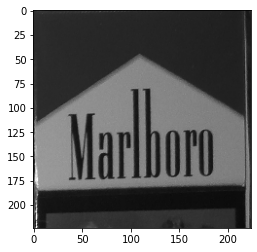

In [9]:
### Visualizing Train Data
plt.imshow(X[0])

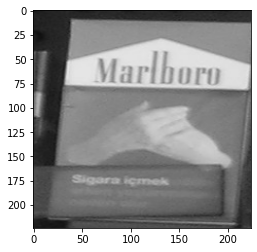

In [10]:
### Visualizing the Test Data
plt.imshow(test_x[200])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of the classes')

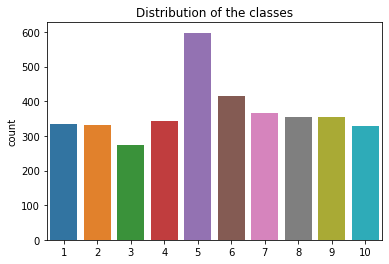

In [11]:
### Visulaizing the class distribution to understand the spread of Training data
sns.countplot(Y)       
plt.title("Distribution of the classes")

From this plot, we can understand the distribution of the classes, but the thumb of image classifiactions models, being training data having atleast a thousand data points, in each class, but here it is less so what we can do is, we can do is image augumentation to over come the abundance, but before that we try in a plain form.

In [ ]:
from keras.utils import np_utils
X = np.array(X)                                       ## Converting Image to Array 
le_ = LabelEncoder()                                  ## Label Encoding of Category
Y = (le_.fit_transform(Y))
Y= np_utils.to_categorical(Y)


test_x = np.array(test_x)
test_y = (le_.fit_transform(test_y))
test_y= np_utils.to_categorical(test_y)

## **VGG16 Model**





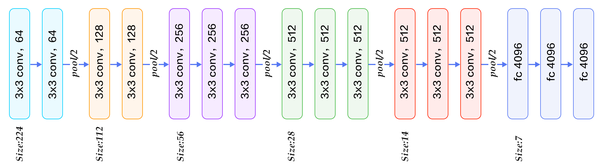

In [ ]:
## In the below function, VGG16 Architecture from the above image has been recreated to the best form
def VGG16_model():
  ## Layer 1
  model = Sequential()                                                                    
  model.add(Convolution2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu")) 
  model.add(Convolution2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.2))

  ## Layer 2
  model.add(Convolution2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Convolution2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.2))

  ## Layer 3
  model.add(Convolution2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Convolution2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Convolution2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.2))

  ## Layer 4
  model.add(Convolution2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Convolution2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Convolution2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.2))

  ## Layer 5
  model.add(Convolution2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Convolution2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Convolution2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))


  ## Layer 6
  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(10, activation='softmax'))

  ## compiling the model
  adam = Adam(lr=1e-5, decay=1e-6)
  model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])

  return model

### VGG16 with Plain Form

In [ ]:
model = VGG16_model()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,Y,test_size=0.1)            ## Splitting the data into train test

In [ ]:
early_stopping = EarlyStopping(patience=5, verbose=1,restore_best_weights=True)  ## early stopping of patience 5

In [ ]:
history = model.fit(X_train, y_train,batch_size=60,epochs=15, callbacks=[early_stopping], validation_data=(X_val,y_val)) ## Training

Epoch 1/30
56/56 [==============================] - 65s 500ms/step - loss: 1.9174 - accuracy: 0.3701 - val_loss: 1.3336 - val_accuracy: 0.6442
Epoch 2/30
56/56 [==============================] - 22s 400ms/step - loss: 0.6885 - accuracy: 0.7985 - val_loss: 0.8642 - val_accuracy: 0.7871
Epoch 3/30
56/56 [==============================] - 22s 400ms/step - loss: 0.3188 - accuracy: 0.8999 - val_loss: 0.6822 - val_accuracy: 0.7439
Epoch 4/30
56/56 [==============================] - 22s 400ms/step - loss: 0.3185 - accuracy: 0.9049 - val_loss: 0.3494 - val_accuracy: 0.9191
Epoch 5/30
56/56 [==============================] - 22s 400ms/step - loss: 0.1107 - accuracy: 0.9722 - val_loss: 0.3248 - val_accuracy: 0.8949
Epoch 6/30
56/56 [==============================] - 22s 400ms/step - loss: 0.1017 - accuracy: 0.9729 - val_loss: 0.2547 - val_accuracy: 0.9191
Epoch 7/30
56/56 [==============================] - 22s 400ms/step - loss: 0.0495 - accuracy: 0.9890 - val_loss: 0.2152 - val_accuracy: 0.9326

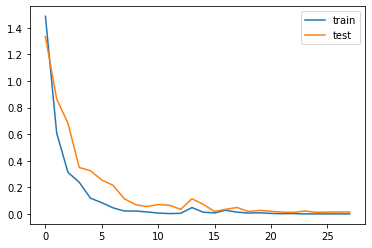

In [ ]:
## plotiing the val loss vs train loss
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

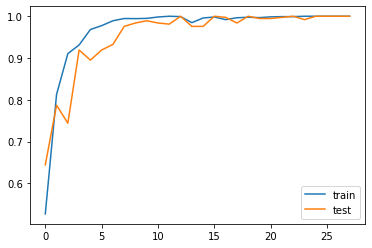

In [ ]:
## plotting val accuracy vs train accuracy
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

In [ ]:
loss, acc = model.evaluate(test_x,test_y,verbose=0)   ##evaluating

In [ ]:
acc*100

10.131195187568665

In [ ]:
preds=model.predict(test_x, verbose=1)      ## predicting

86/86 [==============================] - 5s 60ms/step


In [ ]:
## Manual Evaluation
result = [list(np.where(i == np.amax(i))[0]+1)[0] for i in preds]
y_test =[list(np.where(i == np.amax(i))[0]+1)[0] for i in y_test]

In [ ]:
print("The accuracy is:",acc)
print("The Precison score is:",precision_score(result,y_test,average='micro'))
print("The Recall score is:",recall_score(result,y_test,average='micro'))
print("F-Measure is:",(2*precision_score(result,y_test,average='micro')*recall_score(result,y_test,average='micro'))/(recall_score(result,y_test,average='micro')+precision_score(result,y_test,average='micro')))

### VGG-16 With Data Augumentation


In [18]:
# Generating new images based on combination of height shift, rotation, horizontal flip, brightness range
def data_augumentation(X,Y,val):
  X_ = []
  Y_ = []
  X_.extend(X)
  Y_.extend(Y)
  for i in range(0,len(X)):
    sample_image = expand_dims(X[i], 0)                                                 ## expanding the dimension
    datagenertor = ImageDataGenerator(brightness_range=[0.1,1.0],rotation_range=40,zoom_range=0.2,horizontal_flip=True) ## Creating Image Generator based on height shift
    iterator = datagenertor.flow(sample_image, batch_size=1)         ## Creating Image flow for our input

    for j in range(val):
      batch = iterator.next()                                      ## Iterator to get new image     
      image = batch[0].astype('uint8')                             ## New image       
      try:
        X_.append(cv2.resize(image,(224,224)))                        ## Resizing for Vgg format                                           ## Assigning Category 
        Y_.append(Y[i])
      except:
        continue

  return X_,Y_

In [ ]:
model = VGG16_model()

In [ ]:
X,Y = get_train_data()
test_x, test_y = get_test_data()

In [ ]:
augmented_X , augmented_Y = data_augumentation(X,Y)

In [ ]:
from keras.utils import np_utils
augmented_X = np.array(augmented_X)                                       ## Converting Image to Array 
le_ = LabelEncoder()                                  ## Label Encoding of Category
augmented_Y = (le_.fit_transform(augmented_Y))
augmented_Y= np_utils.to_categorical(augmented_Y)


test_x = np.array(test_x)
test_y = (le_.fit_transform(test_y))
test_y= np_utils.to_categorical(test_y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(augmented_X,augmented_Y,test_size=0.3)            ## Splitting the data into train test

In [ ]:
early_stopping = EarlyStopping(patience=5, verbose=1,restore_best_weights=True)  ## early stopping of patience 5

In [ ]:
history = model.fit(X_train, y_train,batch_size=60,epochs=15, callbacks=[early_stopping], validation_data=(X_val,y_val)) ## Training

Epoch 1/15
260/260 [==============================] - 304s 980ms/step - loss: 1.5205 - accuracy: 0.5072 - val_loss: 1.5307 - val_accuracy: 0.6082
Epoch 2/15
260/260 [==============================] - 252s 969ms/step - loss: 0.3909 - accuracy: 0.9004 - val_loss: 0.9712 - val_accuracy: 0.7624
Epoch 3/15
260/260 [==============================] - 252s 970ms/step - loss: 0.1592 - accuracy: 0.9622 - val_loss: 0.6291 - val_accuracy: 0.8241
Epoch 4/15
260/260 [==============================] - 252s 969ms/step - loss: 0.1009 - accuracy: 0.9751 - val_loss: 0.3299 - val_accuracy: 0.9132
Epoch 5/15
260/260 [==============================] - 252s 969ms/step - loss: 0.0457 - accuracy: 0.9891 - val_loss: 0.3538 - val_accuracy: 0.9180
Epoch 6/15
260/260 [==============================] - 252s 970ms/step - loss: 0.0344 - accuracy: 0.9933 - val_loss: 0.3153 - val_accuracy: 0.9153
Epoch 7/15
260/260 [==============================] - 252s 970ms/step - loss: 0.0282 - accuracy: 0.9929 - val_loss: 0.3183 -

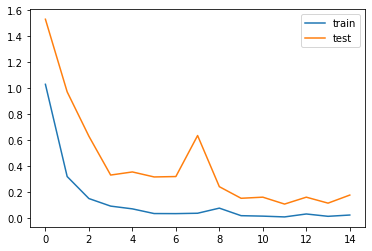

In [ ]:
## plotiing the val loss vs train loss
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

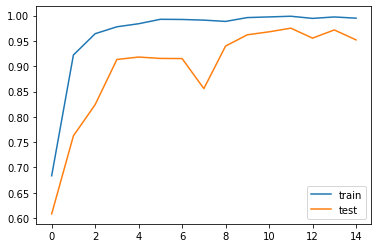

In [ ]:
## plotting val accuracy vs train accuracy
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

In [ ]:
loss,acc = model.evaluate(test_x,test_y)

86/86 [==============================] - 23s 189ms/step - loss: 10.1834 - accuracy: 0.1246


In [ ]:
acc

0.12463556975126266

## **VGG16 with ImageNet + Data AUgumetation**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,Y,test_size=0.3)            ## Splitting the data into train test

In [ ]:
augmented_train_X , augmented_train_Y = data_augumentation(X_train,y_train,4)
augmented_val_X , augmented_val_Y = data_augumentation(X_val,y_val,2)

X_train.extend(augmented_train_X)
y_train.extend(augmented_train_Y)


X_val.extend(augmented_val_X)
y_val.extend(augmented_val_Y)

In [11]:
## Label Encoding the Data
def Lable_Encoding(x,y):
  x = np.array(x)                                       ## Converting Image to Array 
  le_ = LabelEncoder()                                  ## Label Encoding of Category
  y = (le_.fit_transform(y))
  y = np_utils.to_categorical(y)

  return x, y

In [ ]:
X_train, y_train = Lable_Encoding(X_train,y_train)
X_val, y_val = Lable_Encoding(X_val,y_val)
test_x, test_y = Lable_Encoding(test_x,test_y)

In [10]:
### Transfer Learning VGG16 Model
def VGG16_with_imagenet():
  img_height,img_width = 224,224          ## default input size
  num_classes = 10                         ## Total Classes

  base_model = VGG16(weights='imagenet', include_top=False, input_shape= (img_height,img_width,3))

  ## Final dense layers
  x = base_model.output           ## getting features
  x = GlobalAveragePooling2D()(x) ## Average Pooling
  x = Dropout(0.3)(x)             ## Dropout

  ## Final softmax layer
  predictions = Dense(num_classes, activation= 'softmax')(x)  
  model = Model(inputs = base_model.input, outputs = predictions)

  # compiling the model
  adam = Adam(lr=1e-5, decay=1e-6)
  model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
## Running the Model
model = VGG16_with_imagenet()
filepath="/content/drive/MyDrive/Checkpoints/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(patience=5, verbose=1,restore_best_weights=True)  ## early stopping of patience 5
history = model.fit(X_train, y_train,batch_size=60,epochs=15, callbacks=[checkpoint,early_stopping], validation_data=(X_val,y_val)) ## Training

Epoch 1/15
259/259 [==============================] - 277s 885ms/step - loss: 1.4752 - accuracy: 0.6209 - val_loss: 0.0067 - val_accuracy: 0.9995

Epoch 00001: val_accuracy improved from -inf to 0.99955, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-01-1.00.hdf5
Epoch 2/15
259/259 [==============================] - 232s 895ms/step - loss: 0.0184 - accuracy: 0.9967 - val_loss: 0.0016 - val_accuracy: 0.9998

Epoch 00002: val_accuracy improved from 0.99955 to 0.99977, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-02-1.00.hdf5
Epoch 3/15
259/259 [==============================] - 231s 894ms/step - loss: 0.0060 - accuracy: 0.9992 - val_loss: 7.1116e-04 - val_accuracy: 1.0000

Epoch 00003: val_accuracy improved from 0.99977 to 1.00000, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-03-1.00.hdf5
Epoch 4/15
259/259 [==============================] - 231s 891ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 9.2810e-04

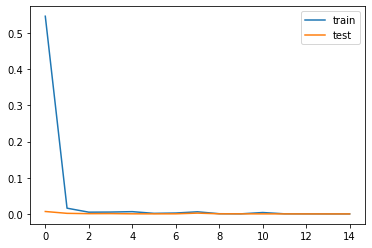

In [ ]:
## plotiing the val loss vs train loss
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

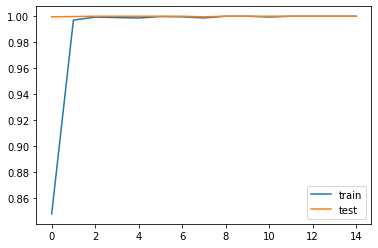

In [ ]:
## plotting val accuracy vs train accuracy
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

In [ ]:
loss,acc = model.evaluate(test_x,test_y)

86/86 [==============================] - 23s 194ms/step - loss: 3.7391 - accuracy: 0.6221


In [ ]:
acc*100

62.20845580101013

## Resnet 50 with ImageNet + Data AUgumetation




In [ ]:
X,Y = get_train_data()
test_x, test_y = get_test_data()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,Y,test_size=0.3)          ## Splitting the data into train test

In [ ]:
augmented_train_X , augmented_train_Y = data_augumentation(X_train,y_train,4)
augmented_val_X , augmented_val_Y = data_augumentation(X_val,y_val,2)

X_train.extend(augmented_train_X)
y_train.extend(augmented_train_Y)


X_val.extend(augmented_val_X)
y_val.extend(augmented_val_Y)

In [ ]:
X_train, y_train = Lable_Encoding(X_train,y_train)
X_val, y_val = Lable_Encoding(X_val,y_val)
test_x, test_y = Lable_Encoding(test_x,test_y)

In [22]:
def Resnet_with_TransferLearning():
  img_height,img_width = 224,224          ## default input size
  num_classes = 10                         ## Total Classes

  ## Loading Resnets from keras to get the feature vector
  base_model = applications.resnet50.ResNet50(weights= "imagenet", include_top=False, input_shape= (img_height,img_width,3))

  ## Final dense layers
  x = base_model.output           ## getting features
  x = GlobalAveragePooling2D()(x) ## Average Pooling
  x = Dropout(0.3)(x)             ## Dropout

  ## Final softmax layer
  predictions = Dense(num_classes, activation= 'softmax')(x)  
  model = Model(inputs = base_model.input, outputs = predictions)

  # compiling the model
  adam = Adam(lr=1e-5, decay=1e-6)
  model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])

  return model 

In [ ]:
model = Resnet_with_TransferLearning():

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
filepath="/content/drive/MyDrive/Checkpoints/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(patience=5, verbose=1,restore_best_weights=True)  ## early stopping of patience 5

In [ ]:
history = model.fit(X_train, y_train,batch_size=60,epochs=30, callbacks=[checkpoint,early_stopping], validation_data=(X_val,y_val)) ## Training

Epoch 1/15
389/389 [==============================] - 292s 647ms/step - loss: 0.9800 - accuracy: 0.7159 - val_loss: 0.0358 - val_accuracy: 0.9950

Epoch 00001: val_accuracy improved from -inf to 0.99505, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-01-1.00.hdf5
Epoch 2/15
389/389 [==============================] - 248s 636ms/step - loss: 0.0114 - accuracy: 0.9993 - val_loss: 0.0020 - val_accuracy: 1.0000

Epoch 00002: val_accuracy improved from 0.99505 to 1.00000, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-02-1.00.hdf5
Epoch 3/15
389/389 [==============================] - 248s 638ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 5.7086e-04 - val_accuracy: 1.0000

Epoch 00003: val_accuracy did not improve from 1.00000
Epoch 4/15
389/389 [==============================] - 248s 638ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 2.8362e-04 - val_accuracy: 1.0000

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/1

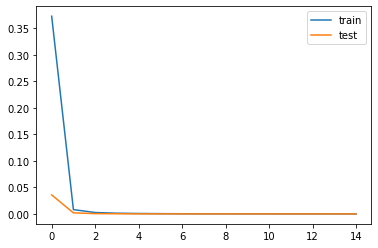

In [ ]:
##  plot val loss vs train loss
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

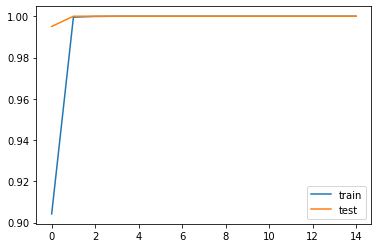

In [ ]:
##  plot val loss vs train loss
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

In [ ]:
loss,acc = model.evaluate(test_x,test_y)

86/86 [==============================] - 10s 106ms/step - loss: 2.1908 - accuracy: 0.3816


In [ ]:
acc*100

38.15597593784332

## Inception V3 with ImageNet + Data AUgumetation

In [ ]:
X,Y = get_train_data()
test_x, test_y = get_test_data()

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X,Y,test_size=0.3)          ## Splitting the data into train test

In [14]:
augmented_train_X , augmented_train_Y = data_augumentation(X_train,y_train,4)
augmented_val_X , augmented_val_Y = data_augumentation(X_val,y_val,2)

X_train.extend(augmented_train_X)
y_train.extend(augmented_train_Y)


X_val.extend(augmented_val_X)
y_val.extend(augmented_val_Y)

In [15]:
X_train, y_train = Lable_Encoding(X_train,y_train)
X_val, y_val = Lable_Encoding(X_val,y_val)
test_x, test_y = Lable_Encoding(test_x,test_y)

In [23]:
def Inception_with_TransferLearning():
  img_height,img_width = 224,224          ## default input size
  num_classes = 10                         ## Total Classes

  ## Loading Resnets from keras to get the feature vector
  base_model = applications.InceptionV3(weights= "imagenet", include_top=False, input_shape= (img_height,img_width,3))

  ## Final dense layers
  x = base_model.output           ## getting features
  x = GlobalAveragePooling2D()(x) ## Average Pooling
  x = Dropout(0.3)(x)             ## Dropout

  ## Final softmax layer
  predictions = Dense(num_classes, activation= 'softmax')(x)  
  model = Model(inputs = base_model.input, outputs = predictions)

  # compiling the model
  adam = Adam(lr=1e-5, decay=1e-6)
  model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])

  return model

In [19]:
model = Inception_with_TransferLearning()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
filepath="/content/drive/MyDrive/Checkpoints/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(patience=5, verbose=1,restore_best_weights=True)  ## early stopping of patience 5

In [21]:
history = model.fit(X_train, y_train,batch_size=60,epochs=30, callbacks=[checkpoint,early_stopping], validation_data=(X_val,y_val)) ## Training

Epoch 1/30
259/259 [==============================] - 165s 471ms/step - loss: 1.3921 - accuracy: 0.5880 - val_loss: 0.0604 - val_accuracy: 0.9948

Epoch 00001: val_accuracy improved from -inf to 0.99482, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-01-0.99.hdf5
Epoch 2/30
259/259 [==============================] - 123s 476ms/step - loss: 0.0650 - accuracy: 0.9961 - val_loss: 0.0163 - val_accuracy: 0.9984

Epoch 00002: val_accuracy improved from 0.99482 to 0.99842, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-02-1.00.hdf5
Epoch 3/30
259/259 [==============================] - 124s 478ms/step - loss: 0.0194 - accuracy: 0.9984 - val_loss: 0.0076 - val_accuracy: 0.9995

Epoch 00003: val_accuracy improved from 0.99842 to 0.99955, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-03-1.00.hdf5
Epoch 4/30
259/259 [==============================] - 124s 478ms/step - loss: 0.0081 - accuracy: 0.9999 - val_loss: 0.0047 - val_a

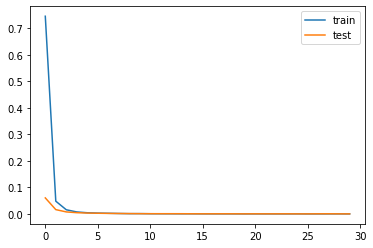

In [22]:
##  plot val loss vs train loss
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

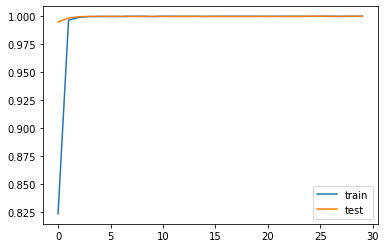

In [23]:
##  plot val loss vs train loss
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

In [24]:
loss,acc = model.evaluate(test_x,test_y)

86/86 [==============================] - 8s 82ms/step - loss: 1.6556 - accuracy: 0.5000


In [25]:
acc*100

50.0

## Remarks

I have used transfer learning of Image net over the data and build the models but the accuracy seems to be very low as 62, 38 and 50 % even after Image Augumentation.

On further investigation, I have found that the train data are very clean and whereas the test data seems to very diry. SO what we can do is introduce few data points from test and train it and see the performance whether it is increasing or not

## **Introducing the Real world pictures for Training**

### VGG-16

In [24]:
X,Y = get_train_data()
test_x, test_y = get_test_data()

In [25]:
## Leaking the data
test_1_x, test_2_x, test_1_y, test_2_y = train_test_split(test_x,test_y,test_size=0.5)            ## Splitting the data

X.extend(test_1_x)
Y.extend(test_1_y)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X,Y,test_size=0.3)          ## Splitting the data into train test

In [27]:
augmented_train_X , augmented_train_Y = data_augumentation(X_train,y_train,4)
augmented_val_X , augmented_val_Y = data_augumentation(X_val,y_val,2)

X_train.extend(augmented_train_X)
y_train.extend(augmented_train_Y)


X_val.extend(augmented_val_X)
y_val.extend(augmented_val_Y)

In [28]:
X_train, y_train = Lable_Encoding(X_train,y_train)
X_val, y_val = Lable_Encoding(X_val,y_val)
test_x, test_y = Lable_Encoding(test_2_x,test_2_y)

In [29]:
## Running the Model
model_vgg = VGG16_with_imagenet()
filepath="/content/drive/MyDrive/Checkpoints/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(patience=5, verbose=1,restore_best_weights=True)  ## early stopping of patience 5
history = model_vgg.fit(X_train, y_train,batch_size=60,epochs=15, callbacks=[checkpoint,early_stopping], validation_data=(X_val,y_val)) ## Training

58892288/58889256 [==============================] - 3s 0us/step
Epoch 1/15
356/356 [==============================] - 348s 842ms/step - loss: 1.5971 - accuracy: 0.5664 - val_loss: 0.0242 - val_accuracy: 0.9954

Epoch 00001: val_accuracy improved from -inf to 0.99540, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-01-1.00.hdf5
Epoch 2/15
356/356 [==============================] - 303s 850ms/step - loss: 0.0388 - accuracy: 0.9918 - val_loss: 0.0116 - val_accuracy: 0.9979

Epoch 00002: val_accuracy improved from 0.99540 to 0.99786, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-02-1.00.hdf5
Epoch 3/15
356/356 [==============================] - 304s 854ms/step - loss: 0.0150 - accuracy: 0.9971 - val_loss: 0.0057 - val_accuracy: 0.9992

Epoch 00003: val_accuracy improved from 0.99786 to 0.99918, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-03-1.00.hdf5
Epoch 4/15
356/356 [==============================] - 303s 851ms/

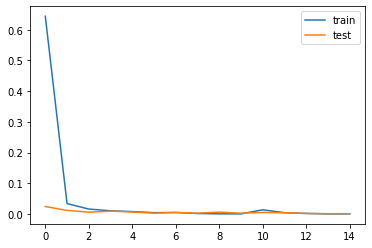

In [30]:
## plotiing the val loss vs train loss
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

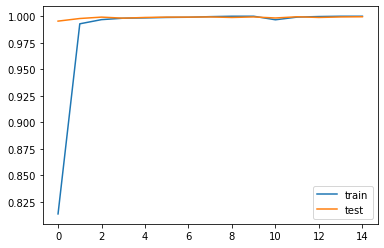

In [31]:
## plotting val accuracy vs train accuracy
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

In [32]:
loss,acc = model_vgg.evaluate(test_x,test_y)

43/43 [==============================] - 12s 132ms/step - loss: 0.0338 - accuracy: 0.9956


In [ ]:
acc

In [66]:
preds=model_vgg.predict(test_x, verbose=1)      ## predicting

43/43 [==============================] - 5s 126ms/step


In [67]:
## Manual Evaluation
result_vgg = [list(np.where(i == np.amax(i))[0]+1)[0] for i in preds]
y_test_vgg =[list(np.where(i == np.amax(i))[0]+1)[0] for i in test_y]

In [68]:
print("The accuracy is:",acc)
print("The Precison score is:",precision_score(result_vgg,y_test_vgg,average='micro'))
print("The Recall score is:",recall_score(result_vgg,y_test_vgg,average='micro'))
print("F-Measure is:",(2*precision_score(result_vgg,y_test_vgg,average='micro')*recall_score(result_vgg,y_test_vgg,average='micro'))/(recall_score(result_vgg,y_test_vgg,average='micro')+precision_score(result,y_test_vgg,average='micro')))

The accuracy is: 0.9919825196266174
The Precison score is: 0.9956268221574344
The Recall score is: 0.9956268221574344
F-Measure is: 0.9974523205478953


### Resnets50

In [39]:
model_res = Inception_with_TransferLearning()

87916544/87910968 [==============================] - 1s 0us/step


In [41]:
filepath="/content/drive/MyDrive/Checkpoints/weights-improvement-resnet-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(patience=5, verbose=1,restore_best_weights=True)  ## early stopping of patience 5

In [42]:
history = model_res.fit(X_train, y_train,batch_size=60,epochs=7, callbacks=[checkpoint,early_stopping], validation_data=(X_val,y_val)) ## Training

Epoch 1/7
356/356 [==============================] - 183s 484ms/step - loss: 1.3825 - accuracy: 0.5796 - val_loss: 0.0941 - val_accuracy: 0.9824

Epoch 00001: val_accuracy improved from -inf to 0.98242, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-resnet-01-0.98.hdf5
Epoch 2/7
356/356 [==============================] - 170s 478ms/step - loss: 0.0921 - accuracy: 0.9830 - val_loss: 0.0236 - val_accuracy: 0.9962

Epoch 00002: val_accuracy improved from 0.98242 to 0.99622, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-resnet-02-1.00.hdf5
Epoch 3/7
356/356 [==============================] - 170s 478ms/step - loss: 0.0221 - accuracy: 0.9982 - val_loss: 0.0126 - val_accuracy: 0.9974

Epoch 00003: val_accuracy improved from 0.99622 to 0.99737, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-resnet-03-1.00.hdf5
Epoch 4/7
356/356 [==============================] - 170s 478ms/step - loss: 0.0087 - accuracy: 0.9991 - val_los

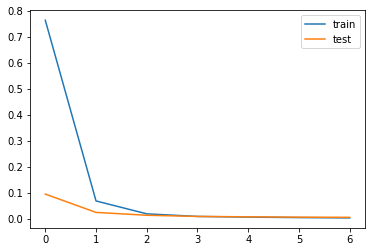

In [43]:
##  plot val loss vs train loss
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

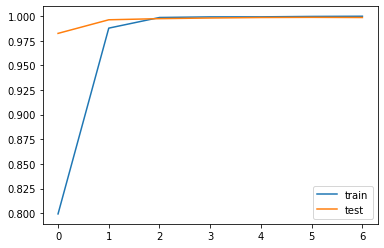

In [44]:
##  plot val loss vs train loss
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

In [50]:
loss,acc = model_res.evaluate(test_x,test_y)

43/43 [==============================] - 5s 71ms/step - loss: 0.0426 - accuracy: 0.9905


In [51]:
acc

0.9905247688293457

In [69]:
preds=model_res.predict(test_x, verbose=1)      ## predicting

43/43 [==============================] - 3s 69ms/step


In [72]:
## Manual Evaluation
result_res = [list(np.where(i == np.amax(i))[0]+1)[0] for i in preds]
y_test_res =[list(np.where(i == np.amax(i))[0]+1)[0] for i in test_y]

In [73]:
print("The accuracy is:",acc)
print("The Precison score is:",precision_score(result_res,y_test_res,average='micro'))
print("The Recall score is:",recall_score(result_res,y_test_res,average='micro'))
print("F-Measure is:",(2*precision_score(result_res,y_test_res,average='micro')*recall_score(result_res,y_test_res,average='micro'))/(recall_score(result_res,y_test_res,average='micro')+precision_score(result,y_test_res,average='micro')))

The accuracy is: 0.9919825196266174
The Precison score is: 0.9905247813411079
The Recall score is: 0.9905247813411079
F-Measure is: 0.9897964542960042


### Inception V3


In [55]:
model_inception = Inception_with_TransferLearning()

In [56]:
filepath="/content/drive/MyDrive/Checkpoints/weights-improvement-inception-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(patience=5, verbose=1,restore_best_weights=True)  ## early stopping of patience 5

In [57]:
history = model_inception.fit(X_train, y_train,batch_size=60,epochs=5, callbacks=[checkpoint,early_stopping], validation_data=(X_val,y_val)) ## Training

Epoch 1/5
356/356 [==============================] - 178s 482ms/step - loss: 1.3632 - accuracy: 0.5844 - val_loss: 0.0877 - val_accuracy: 0.9870

Epoch 00001: val_accuracy improved from -inf to 0.98702, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-inception-01-0.99.hdf5
Epoch 2/5
356/356 [==============================] - 170s 479ms/step - loss: 0.0878 - accuracy: 0.9850 - val_loss: 0.0238 - val_accuracy: 0.9959

Epoch 00002: val_accuracy improved from 0.98702 to 0.99589, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-inception-02-1.00.hdf5
Epoch 3/5
356/356 [==============================] - 170s 478ms/step - loss: 0.0228 - accuracy: 0.9965 - val_loss: 0.0124 - val_accuracy: 0.9979

Epoch 00003: val_accuracy improved from 0.99589 to 0.99786, saving model to /content/drive/MyDrive/Checkpoints/weights-improvement-inception-03-1.00.hdf5
Epoch 4/5
356/356 [==============================] - 170s 478ms/step - loss: 0.0095 - accuracy: 0.9991 

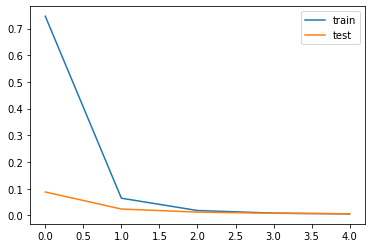

In [58]:
##  plot val loss vs train loss
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

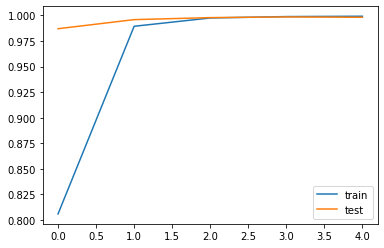

In [59]:
##  plot val loss vs train loss
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

In [60]:
loss,acc = model_inception.evaluate(test_x,test_y)

43/43 [==============================] - 3s 71ms/step - loss: 0.0342 - accuracy: 0.9920


In [61]:
acc

0.9919825196266174

In [74]:
preds=model_inception.predict(test_x, verbose=1)      ## predicting

43/43 [==============================] - 3s 70ms/step


In [75]:
## Manual Evaluation
result_inc = [list(np.where(i == np.amax(i))[0]+1)[0] for i in preds]
y_test_inc =[list(np.where(i == np.amax(i))[0]+1)[0] for i in test_y]

In [76]:
print("The accuracy is:",acc)
print("The Precison score is:",precision_score(result_inc,y_test_inc,average='micro'))
print("The Recall score is:",recall_score(result_inc,y_test_inc,average='micro'))
print("F-Measure is:",(2*precision_score(result_inc,y_test_inc,average='micro')*recall_score(result_inc,y_test_inc,average='micro'))/(recall_score(result_inc,y_test_inc,average='micro')+precision_score(result,y_test_inc,average='micro')))

The accuracy is: 0.9919825196266174
The Precison score is: 0.9919825072886297
The Recall score is: 0.9919825072886297
F-Measure is: 0.9919825072886297


### Remarks

After introducing the real world pictures we can see that the models have been performing extradionarily well

## **Stacking**

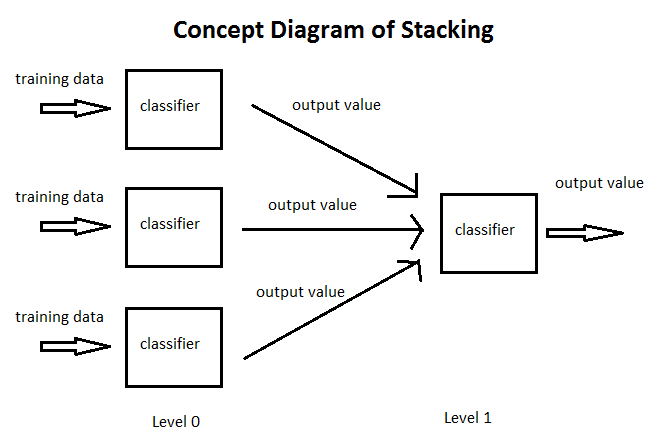

In [80]:
### Using the results of the above 3 models, lets Try to do a maximum voting classifier

df=pd.DataFrame()
df["VGG_16"] = result_vgg
df['Resnet'] = result_res
df['Inception'] = result_inc

In [81]:
df.head()

,VGG_16,Resnet,Inception
0,2,2,2
1,2,2,2
2,5,5,5
3,1,1,1
4,2,2,2


In [87]:
df['Results'] = df.mode(axis=1)[0].astype(int)


In [88]:
print("The accuracy is:",acc)
print("The Precison score is:",precision_score(df['Results'],y_test_inc,average='micro'))
print("The Recall score is:",recall_score(df['Results'],y_test_inc,average='micro'))
print("F-Measure is:",(2*precision_score(df['Results'],y_test_inc,average='micro')*recall_score(df['Results'],y_test_inc,average='micro'))/(recall_score(df['Results'],y_test_inc,average='micro')+precision_score(df['Results'],y_test_inc,average='micro')))

The accuracy is: 0.9919825196266174
The Precison score is: 0.9927113702623906
The Recall score is: 0.9927113702623906
F-Measure is: 0.9927113702623906


### Remarks

Similar to the Models we have made, our ensemble model also performs the best

## **Visualizing the Results**

In [12]:
annotation_df.head()

,filename,Shelf_id,Planogram_id,xmin,ymin,width,height,xmax,ymax,Class
0,C1_P01_N2_S4_1.JPG,C1_P01,N2_S4_1,912,752,260,440,1172,1192,1
1,C1_P01_N1_S3_1.JPG,C1_P01,N1_S3_1,1276,1828,276,448,1552,2276,1
2,C1_P01_N2_S4_1.JPG,C1_P01,N2_S4_1,1140,820,260,404,1400,1224,1
3,C1_P01_N1_S3_1.JPG,C1_P01,N1_S3_1,1548,1836,276,448,1824,2284,1
4,C1_P01_N1_S5_1.JPG,C1_P01,N1_S5_1,1068,1108,208,308,1276,1416,1


In [13]:
test_ = annotation_df.loc[annotation_df['filename']=='C1_P01_N2_S4_1.JPG']
test_ ## We can see four objects are there for testing

,filename,Shelf_id,Planogram_id,xmin,ymin,width,height,xmax,ymax,Class
0,C1_P01_N2_S4_1.JPG,C1_P01,N2_S4_1,912,752,260,440,1172,1192,1
2,C1_P01_N2_S4_1.JPG,C1_P01,N2_S4_1,1140,820,260,404,1400,1224,1
1379,C1_P01_N2_S4_1.JPG,C1_P01,N2_S4_1,1152,1432,216,356,1368,1788,4
1411,C1_P01_N2_S4_1.JPG,C1_P01,N2_S4_1,1384,1440,216,356,1600,1796,4
1430,C1_P01_N2_S4_1.JPG,C1_P01,N2_S4_1,924,1428,216,356,1140,1784,4


In [14]:
## Function to get Test Data
def get_data_predicition():
  test_x = []
  test_y = []

  for i in range(0,len(test_)):
    Class,xmin,ymin,xmax,ymax = test_.iloc[i][['Class', 'xmin', 'ymin', 'xmax', 'ymax']]
    image = cv2.imread(test_data+test_.iloc[i]['filename'], cv2.IMREAD_GRAYSCALE) ## Reading the images as grayscale
    try:
      image = (np.array(image[ymin:ymax, xmin:xmax]))
      image = cv2.resize(image,(224,224))                                  ## Resizing the images to 224x224 as vgg-16 formal size
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                       ## Converting back to RGB 
      test_x.append(image)                                                 ## Adding image to Test X 
      test_y.append(Class)                                                 ## Adding Test Y       
    except:
      continue
  return test_x,test_y

In [34]:
model_vgg = VGG16_with_imagenet()
model_vgg.load_weights("/content/drive/MyDrive/Checkpoints/weights-improvement-03-1.00.hdf5")

In [29]:
vis_x,vis_y = get_data_predicition()
#vis_x, vis_y = Lable_Encoding(vis_x,vis_y)

In [24]:
y= [[0]*10 for i in range(0,len(vis_y))]
for i in range(0,(len(y))):
  for j in range(0,10):
    if j+1 ==vis_y[i]:
      y[i][j]=1.0

In [35]:
vis_x = np.array(vis_x)

In [37]:
results = model_vgg.predict(vis_x)
results =[list(np.where(i == np.amax(i))[0]+1)[0] for i in results]

In [38]:
test_['Results']= results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


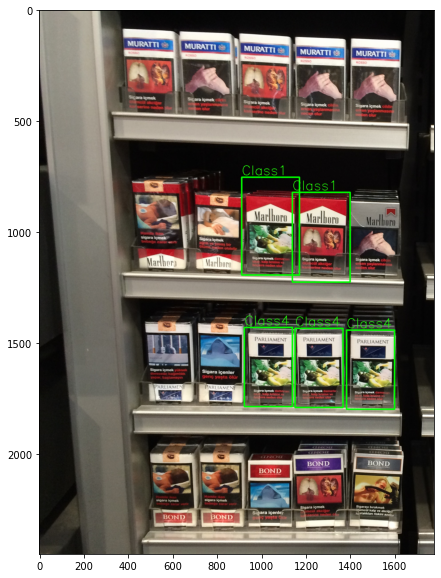

In [41]:
## Function to Understand, how image annotation works
def visualize_Results():
    coordinates = test_[['xmin', 'ymin', 'xmax', 'ymax','Results']].values
    
    ## Reading the image files
    im = cv2.imread(test_data+test_['filename'][0])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 
    
    ## Draw coordinates
    for xmin, ymin, xmax, ymax,results in coordinates:
        cv2.rectangle(im, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 5)
        cv2.putText(im, 'Class'+str(results), (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 2)
    plt.figure(figsize = (30,10))
    plt.imshow(im)

visualize_Results()